In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [145]:
pubs = json.load(open("citations-june_2019.json","r"))

In [146]:
citesy = {}
for p in pubs:
    for k, nk in p["cites_per_year"].items():
        k = int(k)
        if k in citesy:
            citesy[k]+=nk
        else:
            citesy[k]=nk

In [147]:
papersy = {}
for p in pubs:
    y=p["bib"]["year"]
    if y in papersy:
        papersy[y] += 1
    else:
        papersy[y] = 1

Text(0, 0.5, 'n. of citations')

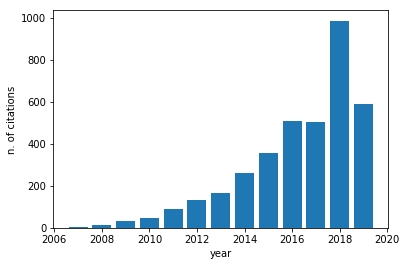

In [148]:
plt.bar(x=list(citesy.keys()), height=list(citesy.values()))
plt.xlabel("year")
plt.ylabel("n. of citations")

Text(0, 0.5, 'n. of papers')

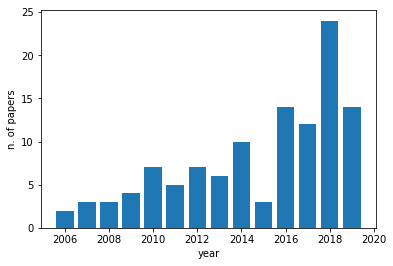

In [149]:
plt.bar(x=list(papersy.keys()), height=list(papersy.values()))
plt.xlabel("year")
plt.ylabel("n. of papers")

In [150]:
np.asarray(list(papersy.values())).sum()

114

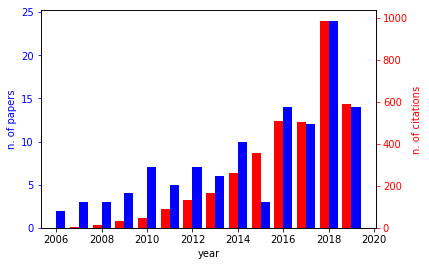

In [212]:
fig, ax1 = plt.subplots()
ax1.bar(x=list(papersy.keys()), height=list(papersy.values()),align="edge",width=0.4,color='b')
ax1.set_xlabel('year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('n. of papers', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(x=list(citesy.keys()), height=list(citesy.values()),align="edge",width=-0.4,color='r')
ax2.set_ylabel('n. of citations', color='r')
ax2.tick_params('y', colors='r')

fig1=fig
fig.savefig("papercites.png",dpi=300)

In [152]:
papercites = np.asarray([(p["citedby"] if "citedby" in p else 0) for p in pubs])

In [153]:
years = []
paperyc = []
for p in pubs:
    pcitesy = {}
    for k, nk in p["cites_per_year"].items():
        k = int(k)
        if k in pcitesy:
            pcitesy[k]+=nk
        else:
            pcitesy[k]=nk
    years += list(pcitesy.keys())
    paperyc.append(pcitesy)
years = list(set(years))
years.sort()
ypcites = np.zeros((len(pubs),len(years) ))
for ip, p in enumerate(paperyc):
    for k,v in p.items():
        ik = years.index(k)
        ypcites[ip, ik] = v

In [154]:
ypcum = ypcites.cumsum(axis=1)

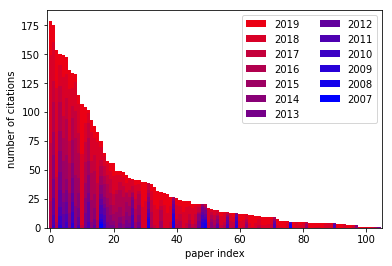

In [209]:
fig, ax1 = plt.subplots()
for b in range(len(years)-1,-1,-1):
    ax1.bar(range(len(pubs)),ypcum[:,b],width=1,label=str(years[b]), color=(b/len(years),0,1-b/len(years)))
ax1.legend(ncol=2)
ax1.set_xlabel("paper index")
ax1.set_ylabel("number of citations")
ax1.set_xlim(-1,105)
fig2 = fig
fig.savefig("paperhistory.png",dpi=300)

(-1, 105)

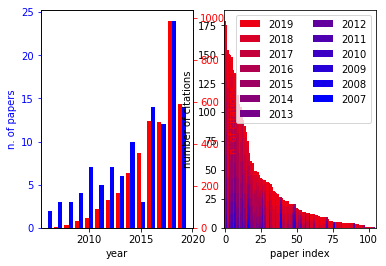

In [213]:
combo, axs= plt.subplots(ncols=2, nrows=1)
ax1 = axs[0]
ax1.bar(x=list(papersy.keys()), height=list(papersy.values()),align="edge",width=0.4,color='b')
ax1.set_xlabel('year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('n. of papers', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(x=list(citesy.keys()), height=list(citesy.values()),align="edge",width=-0.4,color='r')
ax2.set_ylabel('n. of citations', color='r')
ax2.tick_params('y', colors='r')

ax1 = axs[1]
for b in range(len(years)-1,-1,-1):
    ax1.bar(range(len(pubs)),ypcum[:,b],width=1,label=str(years[b]), color=(b/len(years),0,1-b/len(years)))
ax1.legend(ncol=2)
ax1.set_xlabel("paper index")
ax1.set_ylabel("number of citations")
ax1.set_xlim(-1,105)

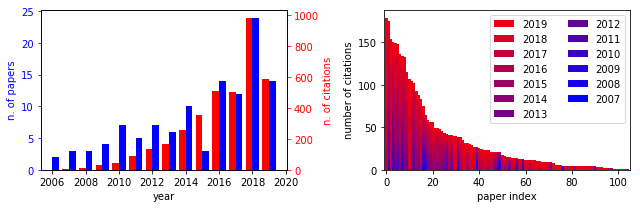

In [214]:
combo.set_size_inches(9,3)
combo.tight_layout()
combo.savefig("citationdata.png",dpi=300)
combo

In [215]:
print(np.mean(papercites),np.median(papercites))

32.6578947368421 13.5
